In [28]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt

In [29]:
def get_blocks(img, block_size=512, stride=512):
    h, w = img.shape
    blocks = []

    for y in range(0, h - block_size + 1, stride):
        for x in range(0, w - block_size + 1, stride):
            blocks.append(img[y:y+block_size, x:x+block_size])

    return blocks

In [30]:
prnu1 = np.load("prnu/prnu_cam1.npy")
prnu2 = np.load("prnu/prnu_cam2.npy")
T_low  = np.load("prnu/T_low.npy")
T_high = np.load("prnu/T_high.npy")

print(T_low, T_high)

0.0033671889 0.03222487


In [31]:
def center_crop(img, size=2048):
    h, w = img.shape
    size = min(size, h, w)
    half = size // 2
    return img[h//2-half:h//2+half, w//2-half:w//2+half]

def extract_residual_wavelet(img):
    img = center_crop(img)

    # Wavelet decomposition
    coeffs = pywt.wavedec2(img, wavelet='db8', level=1)

    # Remove approximation (scene)
    coeffs[0] = np.zeros_like(coeffs[0])

    # Reconstruct noise
    r = pywt.waverec2(coeffs, wavelet='db8')

    return r - np.mean(r)

def correlate(img, prnu):
    r = extract_residual_wavelet(img)

    h, w = r.shape
    p = prnu[:h, :w]        # 🔥 CROP PRNU TO MATCH RESIDUAL
    p = p - np.mean(p)

    num = np.sum(r * p)
    den = (np.linalg.norm(r) * np.linalg.norm(p)) + 1e-8

    return num / den

In [32]:
def load_images(folder):
    imgs = []
    for f in os.listdir(folder):
        if f.lower().endswith((".jpg",".png",".jpeg")):
            img = cv2.imread(os.path.join(folder,f), cv2.IMREAD_GRAYSCALE)
            imgs.append(img.astype(np.float32))
    return imgs

ai_imgs = (
    load_images(r"C:\Users\Saif Kazi\OneDrive\Desktop\dataset\ai\stable_diffusion") +
    load_images(r"C:\Users\Saif Kazi\OneDrive\Desktop\dataset\ai\dalle")
)

print("Total AI images:", len(ai_imgs))

Total AI images: 1012


In [33]:
ai_corrs = []

for img in ai_imgs:
    c = max(correlate(img, prnu1), correlate(img, prnu2))
    ai_corrs.append(c)

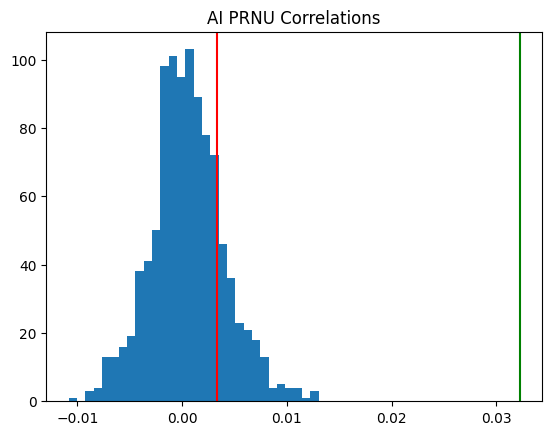

In [34]:
plt.hist(ai_corrs, bins=30)
plt.axvline(T_low, color="r")
plt.axvline(T_high, color="g")
plt.title("AI PRNU Correlations")
plt.show()

In [35]:
print("Max AI corr:", max(ai_corrs))

if max(ai_corrs) < T_low:
    print("✅ AI correctly rejected")
elif max(ai_corrs) < T_high:
    print("⚠️ AI in ambiguous zone (OK)")
else:
    print("❌ ERROR: AI exceeds T_high")

Max AI corr: 0.013038436
⚠️ AI in ambiguous zone (OK)
